# Boston Marathon times

This example of Boston marathon times is an example of using a sparse approximation for fitting a Gaussian process with a lot of data.

In [10]:
import os

os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [11]:
%matplotlib inline
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

warnings.simplefilter("ignore")

In [12]:
marathon_results = pd.read_csv("../data/marathon_results_2015.csv", index_col=0)[
    ["Age", "M/F", "Official Time"]
]
marathon_results["time_hours"] = (
    pd.to_timedelta(marathon_results["Official Time"]).dt.seconds / 3600
)
marathon_results["female"] = marathon_results["M/F"] == "F"
marathon_results = marathon_results[["Age", "female", "time_hours"]].rename(
    {"Age": "age"}, axis=1
)
marathon_results.head()

,age,female,time_hours
0,25,False,2.154722
1,30,False,2.163333
2,29,False,2.172778
3,28,False,2.179722
4,32,False,2.180278


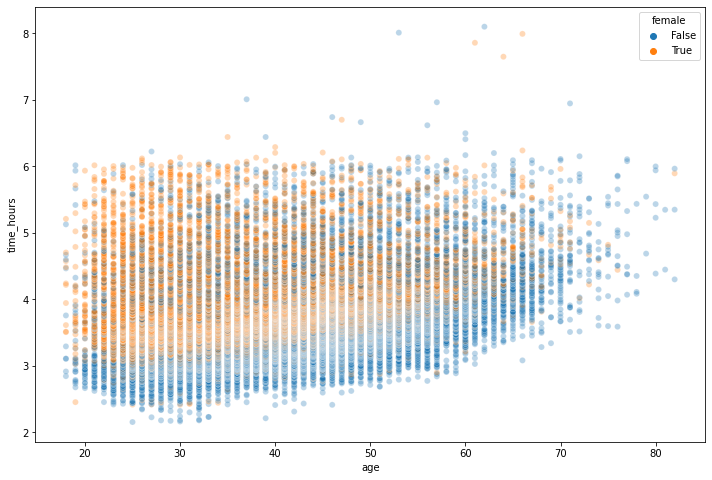

In [13]:
plt.figure(figsize=(12, 8))
sns.scatterplot("age", "time_hours", hue="female", data=marathon_results, alpha=0.3);

In [14]:
X, y = marathon_results.loc[
    marathon_results.female == True, ["age", "time_hours"]
].values.T

In [15]:
with pm.Model() as marathon_model:

    ρ = pm.Exponential("ρ", 1)
    η = pm.Exponential("η", 1)

    K = η ** 2 * pm.gp.cov.ExpQuad(1, ρ)

    gp = pm.gp.MarginalSparse(cov_func=K, approx="FITC")

    # initialize 10 inducing points with K-means
    Xu = pm.gp.util.kmeans_inducing_points(10, X.reshape(-1, 1))

    σ = pm.HalfCauchy("σ", beta=1)
    obs = gp.marginal_likelihood("obs", X=X.reshape(-1, 1), Xu=Xu, y=y, noise=σ)

In [17]:
with marathon_model:
    trace_women = pm.sample(draws=1000, init="advi+adapt_diag", n_init=20000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 11600
Interrupted at 11,599 [57%]: Average Loss = 19,576
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ρ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 226 seconds.


In [18]:
X_pred = np.linspace(20, 80)

with marathon_model:
    f_pred = gp.conditional("f_pred", X_pred.reshape(-1, 1))

In [19]:
with marathon_model:
    pred_samples = pm.sample_posterior_predictive(
        trace_women, vars=[f_pred], samples=1000
    )

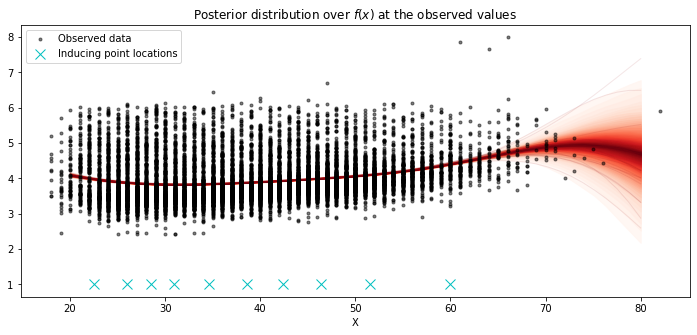

In [20]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples["f_pred"], X_pred)

# plot the data and the true latent function
plt.plot(X, y, "ok", ms=3, alpha=0.5, label="Observed data")
plt.plot(Xu, np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

# axis labels and title
plt.xlabel("X")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();